<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
# !pip install keras==2.2
import pandas as pd
import numpy as np
# import keras 
# from keras_preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
def readTrain():
    train = pd.read_csv("./SPY.csv")
    return train

def augFeatures(train):
    train["Date"]=train.index
    train["Date"] = pd.to_datetime(train["Date"])
    train["year"] = train["Date"].dt.year
    train["month"] = train["Date"].dt.month
    train["date"] = train["Date"].dt.day
    train["day"] = train["Date"].dt.dayofweek
    return train

def normalize(train):
    train = train.drop(["Date"], axis=1)
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.std(x)))
    p=pd.DataFrame([train.mean(),train.std()])
    print(p)
    return train_norm,p

def normalize1(train):
    train = train.drop(["Date"], axis=1)
    train_norm = train.apply(lambda x: np.arctan(x)*2/np.pi)
    return train_norm

def buildTrain(train, pastDay=30, futureDay=5):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["Adj Close"]))
    return np.array(X_train), np.array(Y_train)

def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(8, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(8))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

def splitData1(X,rate):
    x_train = X[:int(X.shape[0]*rate)].drop('close',axis=1)
    y_train = X[:int(X.shape[0]*rate)]['close']
    x_val = X[int(X.shape[0]*rate):int(X.shape[0]*(rate+(1-rate)/2))].drop('close',axis=1)
    y_val = X[int(X.shape[0]*rate):int(X.shape[0]*(rate+(1-rate)/2))]['close']
    x_test = X[int(X.shape[0]*(rate+(1-rate)/2)):].drop('close',axis=1)
    y_test = X[int(X.shape[0]*(rate+(1-rate)/2)):]['close']
    return x_train, y_train, x_val, y_val,x_test ,y_test

In [148]:
# !pip install numpy==1.19.3 -i  http://mirrors.aliyun.com/pypi/simple/ --trusted-host=mirrors.aliyun.com 
# !pip install akshare -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host=mirrors.aliyun.com  --upgrade
import akshare as ak
code="sh600519"
df = ak.stock_zh_index_daily_tx(symbol=code)
# df

In [105]:
train = df
train_Aug = augFeatures(train)
train_norm,p = normalize(train_Aug)
# change the last day and next day
# train_norm = train_Aug.drop(["Date"], axis=1)

         open       close        high         low        amount         year  \
0  261.100805  261.572454  264.678426  258.103375  28278.221014  2010.898136   
1  379.117117  379.831571  383.816459  375.270613  24180.430128     5.587685   

      month       date       day  
0  6.716515  16.184439  2.004985  
1  3.430117   8.581157  1.408753  


In [106]:
train_norm['close']=train_norm['close'].shift(-7)
train_norm=train_norm[:-7]

In [107]:
train_norm.shape

(4607, 9)

In [116]:
#切分数据集
x_train, y_train, x_val, y_val,x_test ,y_test=splitData1(train_norm,0.8)
#转换成数组形式
x_train, y_train, x_val, y_val,x_test ,y_test=np.array(x_train),np.array(y_train),np.array(x_val),np.array(y_val),np.array(x_test),np.array(y_test)
#增加一个维度
x_train, y_train, x_val, y_val,x_test ,y_test=x_train.reshape(x_train.shape[0],1,x_train.shape[1]),y_train.reshape(y_train.shape[0],1),x_val.reshape(x_val.shape[0],1,x_val.shape[1]),y_val.reshape(y_val.shape[0],1),x_test.reshape(x_test.shape[0],1,x_test.shape[1]),y_test.reshape(y_test.shape[0],1)

# X_train, Y_train = buildTrain(train_norm, 30, 1)
# X_train, Y_train = shuffle(X_train, Y_train)
# # because no return sequence, Y_train and Y_val shape must be 2 dimension
# X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 553
Trainable params: 553
Non-trainable params: 0
_________________________________________________________________


In [128]:
model = buildManyToOneModel(x_train.shape)
# callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
# history=model.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_val, y_val), callbacks=[callback])
history=model.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_val, y_val))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
29/29 [==============================] - 0s 13ms/step - loss: 0.1151 - val_loss: 0.6958
Epoch 2/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.7215
Epoch 3/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.7365
Epoch 4/200
29/29 [==============================] - 0s 2ms/step - loss: 0.0096 - val_l

29/29 [==============================] - 0s 2ms/step - loss: 2.7793e-04 - val_loss: 0.1878
Epoch 152/200
29/29 [==============================] - 0s 2ms/step - loss: 2.8046e-04 - val_loss: 0.1891
Epoch 153/200
29/29 [==============================] - 0s 2ms/step - loss: 2.7473e-04 - val_loss: 0.1906
Epoch 154/200
29/29 [==============================] - 0s 2ms/step - loss: 2.7419e-04 - val_loss: 0.1867
Epoch 155/200
29/29 [==============================] - 0s 2ms/step - loss: 2.7431e-04 - val_loss: 0.1897
Epoch 156/200
29/29 [==============================] - 0s 2ms/step - loss: 2.7408e-04 - val_loss: 0.1880
Epoch 157/200
29/29 [==============================] - 0s 2ms/step - loss: 2.7482e-04 - val_loss: 0.1888
Epoch 158/200
29/29 [==============================] - 0s 2ms/step - loss: 2.7548e-04 - val_loss: 0.1870
Epoch 159/200
29/29 [==============================] - 0s 2ms/step - loss: 2.7624e-04 - val_loss: 0.1880
Epoch 160/200
29/29 [==============================] - 0s 2ms/step - 

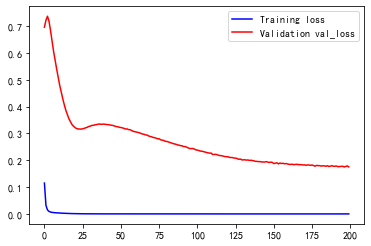

In [129]:
epochs=range(len(history.history['loss']))
plt.figure()
plt.plot(epochs,history.history['loss'],'b',label='Training loss')
plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
plt.legend()
# plt.savefig('/root/notebook/help/figure/model_V3.1_loss.jpg')

In [130]:
y_predict=model.predict(x_test)
from sklearn.metrics import mean_squared_error
# mean_squared_error(y_test,y_predict)

In [131]:
mean_squared_error(y_test,y_predict)

4.287453139166945

In [135]:
def normalize2(df):
#     df=df.drop('Date',axis=1)
    for i in df.columns:
        df[i]=df[i].apply(lambda x:(x-p[i][0])/(p[i][1]-p[i][2]))
    return df
def notnormalize2(y_predict1):
    y_predict2=[]
    for i in y_predict1:
        y_predict2.append(p['close'][0]+(i*p['close'][1]))
    return y_predict2
pred_test=notnormalize2(y_predict)
y_test=notnormalize2(y_test)

In [53]:
# plt.figure(figsize=(20, 10))
# plt.plot(np.arange(1,len(y_test)+1),y_test, 'r-',label='Test')
# plt.plot(np.arange(1,len(pred_test)+1),pred_test, 'g-',label='pred_test')
# plt.legend(loc='best')
# plt.show()

# plt.xlabel('pred_test')
# plt.ylabel('y_test')
# plt.scatter(pred_test,y_test,marker='.')
# plt.show()

In [138]:
df = ak.stock_zh_index_daily_tx(symbol="sh000919")
d=df[-7:]

In [139]:
d1=augFeatures(d)
date=d1['Date'][-1]
# d1

In [140]:
def normalize2(df):
    df=df.drop('Date',axis=1)
    for i in df.columns:
        df[i]=df[i].apply(lambda x:(x-p[i][0])/(p[i][1]))
    return df
d1 = normalize2(d1)
d2=d1.drop('close',axis=1)
# d2

In [141]:
d2=np.array(d2).reshape(d2.shape[0],1,d2.shape[1])
# d2

In [142]:
y_predict1=model.predict(d2)
# y_predict1

In [143]:
def notnormalize2(y_predict1):
    y_predict2=[]
    for i in y_predict1:
        y_predict2.append(p['close'][0]+i*(p['close'][1]))
    return y_predict2

In [144]:
pred_test=notnormalize2(y_predict1)

In [145]:
# pred_test

In [150]:
d3=pd.DataFrame(y_predict1)

In [151]:
msg=str(date).split(' ')[0]+'之后7天的预测值'+str(d3[0].values.tolist())

In [152]:
import requests
requests.get('https://sc.ftqq.com/SCU128831T37074ab313300c27cb0187ed02ae06215fba1a3315473.send?text=' +code+ '&desp=预测情况：' + msg)


<Response [200]>

In [154]:
!pip --default-timeout=6666 install pyspark

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    pyspark from https://pypi.tuna.tsinghua.edu.cn/packages/f0/26/198fc8c0b98580f617cb03cb298c6056587b8f0447e20fa40c5b634ced77/pyspark-3.0.1.tar.gz#sha256=38b485d3634a86c9a2923c39c8f08f003fdd0e0a3d7f07114b2fb4392ce60479:
        Expected sha256 38b485d3634a86c9a2923c39c8f08f003fdd0e0a3d7f07114b2fb4392ce60479
             Got        dffdf74d792c037196c5d956ecda48ab0e8cf4c7a3f1cbe193bc1e8bca1b2c74

